In [63]:
import numpy as np
import pandas as pd

In [64]:
df = pd.read_csv('dataset.csv')

In [65]:
# Combine Date + Time for a clean time column
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True
)

In [106]:
#Map traffic levels to numeric
traffic_map = {'low': 0.5, 'medium': 1.5, 'average': 2.0, 'high': 3.0}
df['TrafficLevel'] = df['TrafficConditionNearby'].map(traffic_map)

In [107]:
#Map vehicle type to weights
vehicle_map = {'cycle': 0.5, 'car': 1.5, 'bike': 1.0, 'truck': 2.0}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)

In [108]:
# Calculate occupancy rate
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
df['IsSpecialDay'] = df['IsSpecialDay'].astype(int) 

In [109]:
df['BasePrice'] = 10

alpha = 0.5
theta = 2
beta = 0.2
gamma = 0.3
eta = 1.5
delta = 0.5
epsilon = 0.2


#Saturation effect for occupancy — price should increase sharply near full occupancy, but not linearly.
#Queue length effect — each extra car in the queue should increase price, but with diminishing returns.
#Traffic level — smooth non-linear scaling (e.g., exponential or power function).
#Special day impact — could multiply the entire surge factor instead of adding linearly.
#Vehicle type — modeled as a multiplier too (premium factor).

In [110]:
def calculate_raw_demand(row):
    occupancy_effect = alpha * (row['OccupancyRate'] ** theta)
    queue_effect = beta * np.log(1 + row['QueueLength'])
    traffic_effect = gamma * (row['TrafficLevel'] ** eta)
    special_day_effect = delta * row['IsSpecialDay']
    vehicle_effect = epsilon * row['VehicleWeight']

    raw_demand = occupancy_effect + queue_effect + traffic_effect + special_day_effect + vehicle_effect

    return raw_demand

#Nonlinear terms (square, log) let you adjust how sharply prices rise when factors spike.


In [111]:
df['RawDemand'] = df.apply(calculate_raw_demand, axis=1)

In [112]:
from scipy.special import expit 
df['PriceMultiplier'] = 0.5 + 1.5 * expit(df['RawDemand'])

In [113]:
df['Price'] = df['BasePrice'] * df['PriceMultiplier']

In [114]:
print(df[['RawDemand', 'PriceMultiplier', 'Price']].head())

   RawDemand  PriceMultiplier      Price
0   0.550284         1.451302  14.513021
1   0.550847         1.451498  14.514981
2   0.635400         1.480569  14.805694
3   0.642983         1.483141  14.831411
4   0.559579         1.454533  14.545328


In [115]:
df.to_csv('Model_2_pricing_output.csv', index=False)

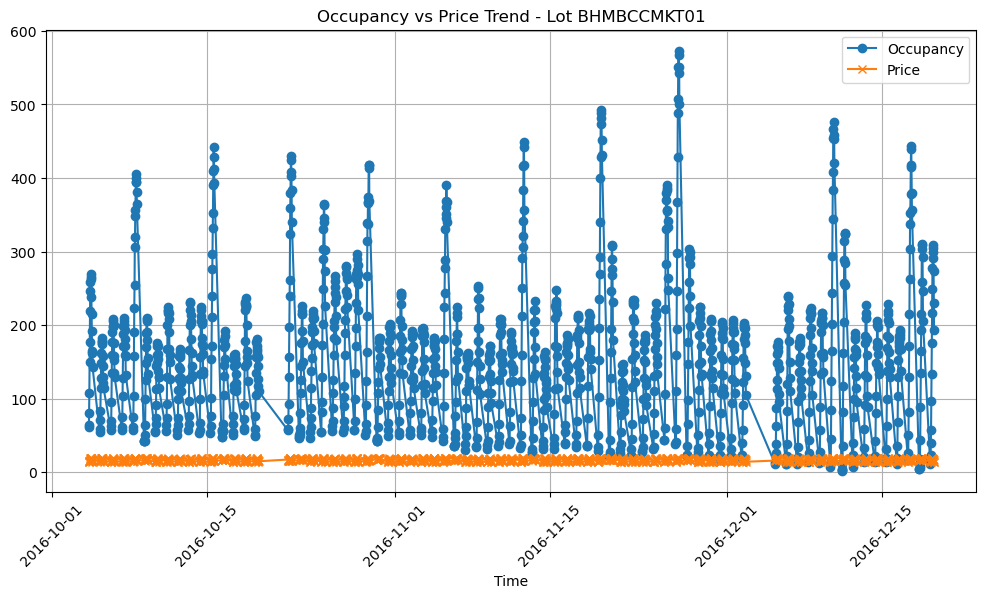

In [116]:
import matplotlib.pyplot as plt

# Pick one parking lot to check
lot_id = df['SystemCodeNumber'].unique()[0]
lot_df = df[df['SystemCodeNumber'] == lot_id].copy().sort_values('Timestamp')

plt.figure(figsize=(12, 6))

# Plot Occupancy (scaled if needed)
plt.plot(lot_df['Timestamp'], lot_df['Occupancy'], marker='o', label='Occupancy')

# Plot Price
plt.plot(lot_df['Timestamp'], lot_df['Price'], marker='x', label='Price')

plt.xlabel('Time')
plt.title(f'Occupancy vs Price Trend - Lot {lot_id}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


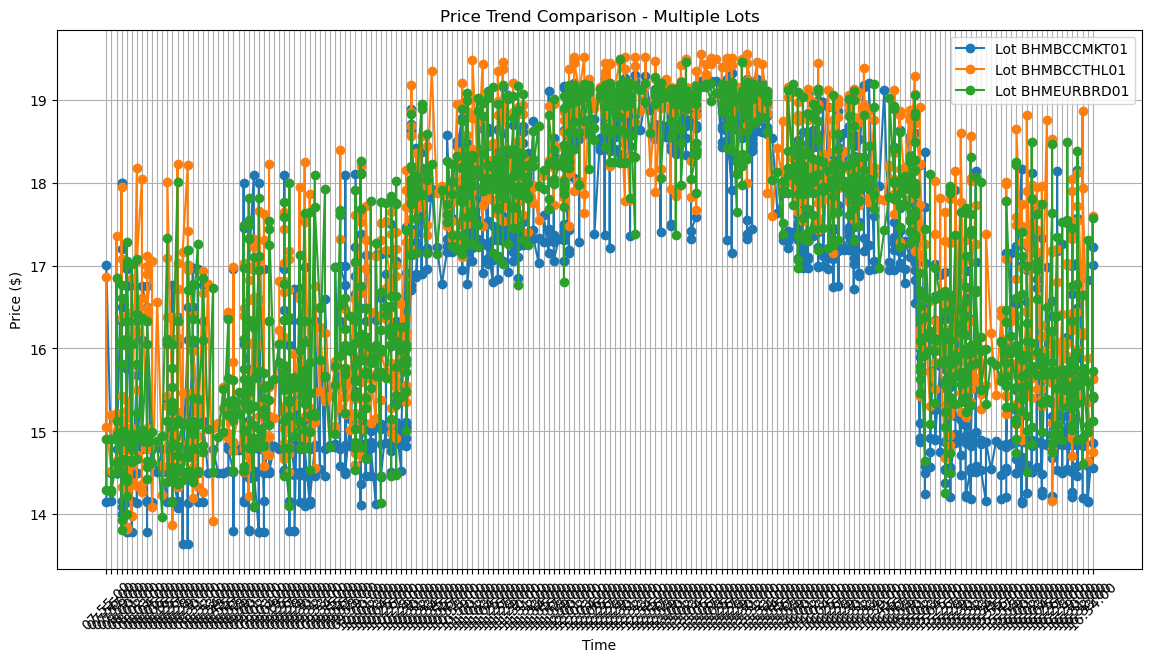

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Loop through 3 parking lots (or however many you want)
for lot_id in df['SystemCodeNumber'].unique()[:3]:
    lot_df = df[df['SystemCodeNumber'] == lot_id].copy().sort_values('LastUpdatedTime')
    plt.plot(lot_df['LastUpdatedTime'], lot_df['Price'], marker='o', label=f'Lot {lot_id}')

plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title('Price Trend Comparison - Multiple Lots')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
